classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch 5/ 5, loss: 0.2537


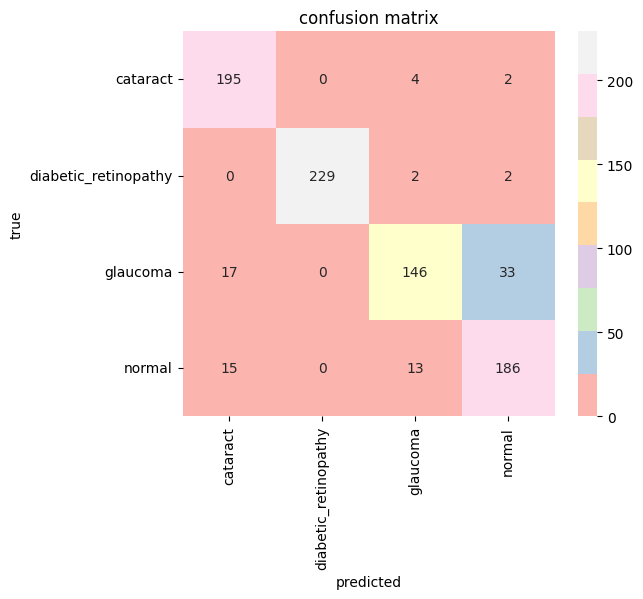

                      precision    recall  f1-score   support

            cataract       0.86      0.97      0.91       201
diabetic_retinopathy       1.00      0.98      0.99       233
            glaucoma       0.88      0.74      0.81       196
              normal       0.83      0.87      0.85       214

            accuracy                           0.90       844
           macro avg       0.89      0.89      0.89       844
        weighted avg       0.90      0.90      0.89       844



In [23]:
# importing libraries 

import numpy as np 
import matplotlib.pyplot as plt 
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import random


# data augmentation + preprocessing 
transform_aug= transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(), #converts img to pytorch tensors
    transforms.Normalize([0.5,0.5, 0.5], [0.5,0.5,0.5])
])

# loading dataset
dataset_path="/kaggle/input/eye-diseases-classification/dataset"
dataset= datasets.ImageFolder(dataset_path, transform=transform_aug)

#splitting into train and test 

train_size= int(0.8*len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

# to feed batches of test/ train data for evaluation
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)
print("classes:", dataset.classes)


#loading pretrained resnet18 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

# replacing final layer to match 4 classes
num_ftrs= model.fc.in_features
model.fc=nn.Linear(num_ftrs,4)
model = model.to(device)

# loss + optimizer 
criterion= nn.CrossEntropyLoss()   #measure how well the model's prediction match actual labels
optimizer= optim.Adam(model.parameters(), lr=0.0005)  #updates model weights during training, lr=learing rate

# training the model

epochs=5
for epoch in range (epochs):
    model.train()
    running_loss=0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad() #clears old gradients
        outputs= model(images) 
        loss= criterion(outputs, labels)
        loss.backward() #backpropagation
        optimizer.step() #update weights
        running_loss += loss.item()

print(f"epoch {epoch+1}/ {epochs}, loss: {running_loss/len(train_loader):.4f}")

# evaluating the model, collects the true and predicted labels for all test samples.

model.eval()
all_labels = []
all_preds= []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs= model(images)
        _, predicted= torch.max(outputs,1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# confusion matrix and classification report 

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns 

cm= confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))   
sns.heatmap(cm, annot=True, fmt='d', cmap='Pastel1', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('predicted')
plt.ylabel('true')
plt.title('confusion matrix')
plt.show()
print(classification_report(all_labels, all_preds, target_names=dataset.classes))


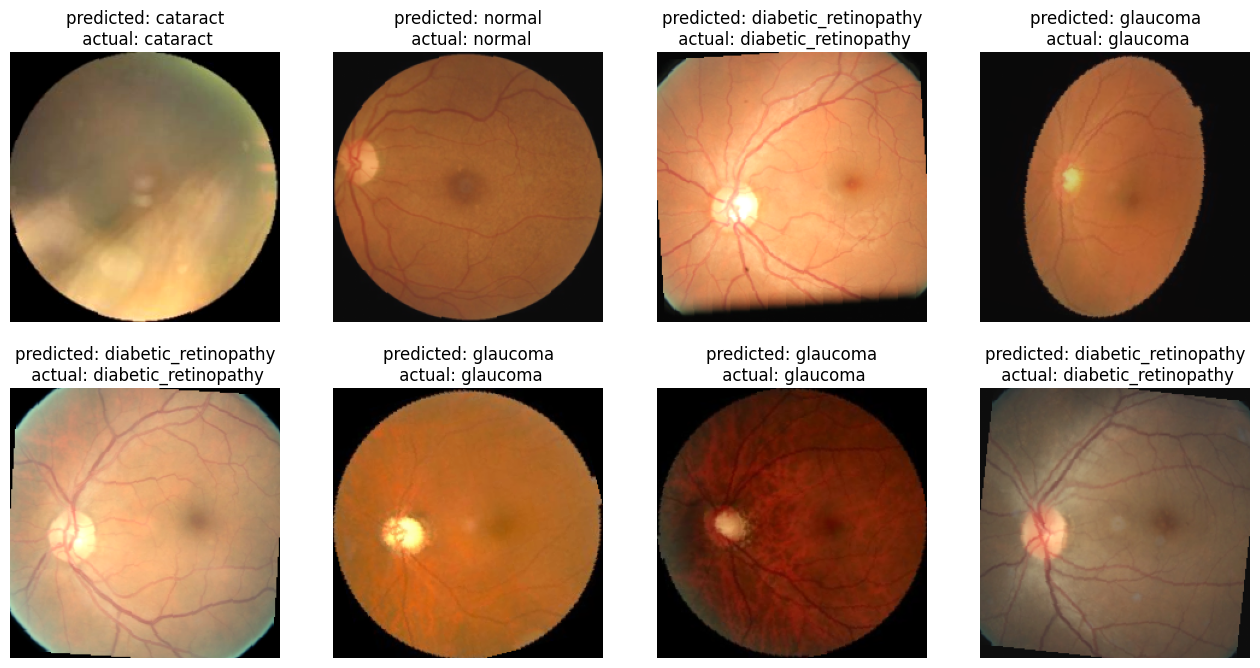

In [24]:
# actual vs predicted images

import random 
import numpy as np 

#function to unnormalize images for display

def imshow(img):
    img= img.numpy().transpose(1,2,0) #convetrs tensor to numpy for easier display, tensors = (c,h,w), img =(h,w,c)
    img = (img*0.5)+0.5  #unnormalizing = pixel =[0,1]
    img=np.clip(img,0,1)
    plt.imshow(img)
    
# picking random 8 test images 

model.eval()
dataiter = iter(test_loader)
images, labels= next(dataiter)

images= images.to(device)
labels= labels.to(device)
outputs= model(images)
_, predicted= torch.max(outputs,1)

plt.figure(figsize=(16,8))
for idx in range(8):
    plt.subplot(2,4, idx+1)
    imshow(images[idx].cpu())   
    plt.title(f"predicted: {dataset.classes[predicted[idx]]}\n actual: {dataset.classes[labels[idx]]}")
    plt.axis('off') 
plt.show()

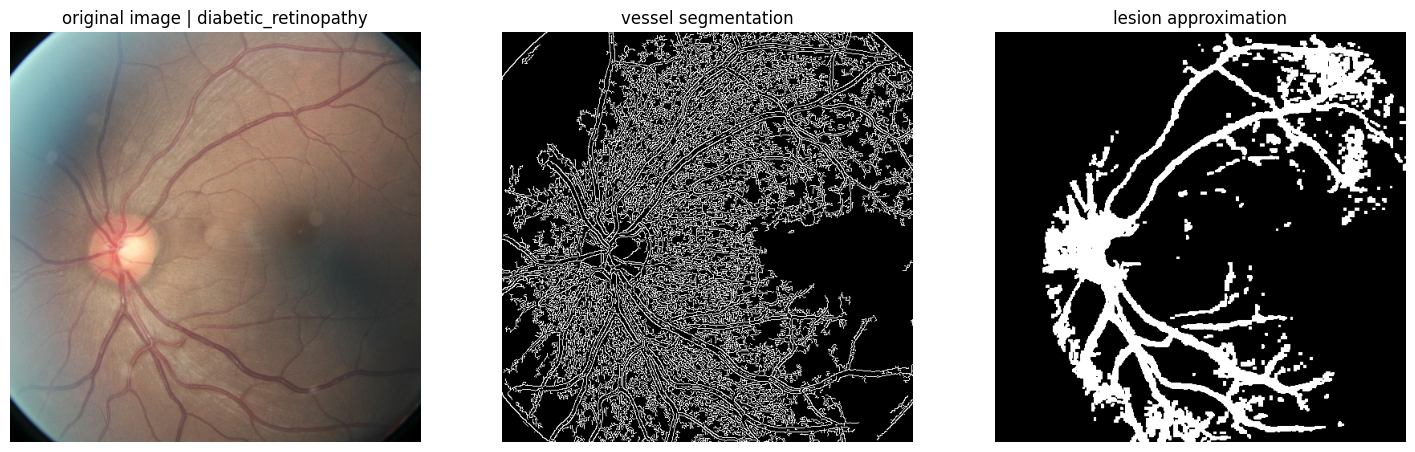

mean RGB: [126.69974899 111.31481552 101.30764008]
std RGB: [43.13806443 36.65380915 35.1503833 ]
brightness: 114.77752685546875
feature vector: [58.13140869140625, 48.27260971069336, 126.69974899291992, 111.31481552124023, 101.3076400756836, 43.138064433621764, 36.65380914834174, 35.150383302809495, 114.77752685546875]


In [25]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

#loading example image
dataset_path = "/kaggle/input/eye-diseases-classification/dataset/diabetic_retinopathy"
images = os.listdir(dataset_path)

img_example = cv2.imread(os.path.join(dataset_path, images[0]))
img_example = cv2.cvtColor(img_example, cv2.COLOR_BGR2RGB)

# vessel segmentation
def vessel_segmentation(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    edges = cv2.Canny(gray, 30, 100)
    return edges

vessels = vessel_segmentation(img_example)

# lesion approximation
def lesion_segmentation(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_red1 = np.array([0,50,50])
    upper_red1 = np.array([10,255,255])
    lower_red2 = np.array([160,50,50])
    upper_red2 = np.array([180,255,255])
    
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    
    mask = cv2.bitwise_or(mask1, mask2)
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask

lesions = lesion_segmentation(img_example)

# plotting
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(img_example)
plt.axis('off')
plt.title("original image | diabetic_retinopathy")

plt.subplot(1,3,2)
plt.imshow(vessels, cmap='gray')
plt.axis('off')
plt.title("vessel segmentation")

plt.subplot(1,3,3)
plt.imshow(lesions, cmap='gray')
plt.axis('off')
plt.title("lesion approximation")

plt.show()

# color and intensity features
def color_features(img):
    mean_rgb = np.mean(img, axis=(0,1))  # mean per channel
    std_rgb = np.std(img, axis=(0,1))    # std per channel
    brightness = np.mean(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    return mean_rgb, std_rgb, brightness

mean_rgb, std_rgb, brightness = color_features(img_example)
print("mean RGB:", mean_rgb)
print("std RGB:", std_rgb)
print("brightness:", brightness)

# feature vector
vessel_density = vessels.sum() / vessels.size
lesion_area = lesions.sum() / lesions.size
feature_vector = [vessel_density, lesion_area, *mean_rgb, *std_rgb, brightness]
print("feature vector:", feature_vector)


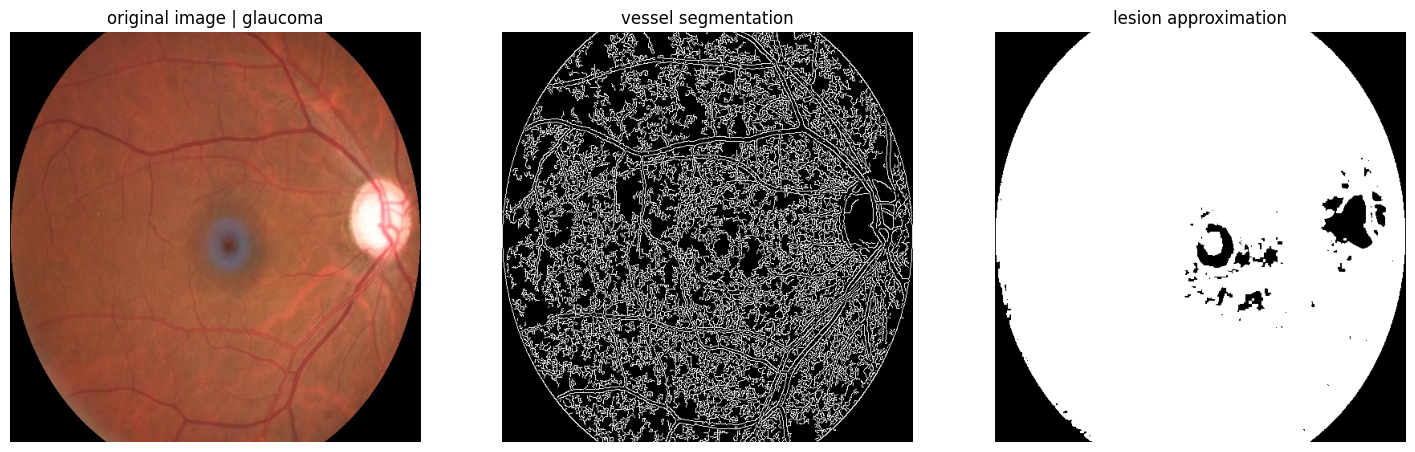

mean rgb: [135.38018417  72.76770401  51.88385391]
std rgb: [58.43615867 36.38833035 30.3590197 ]
brightness: 96.2802365620931
feature vector: [58.1498908996582, 212.83527374267578, 135.38018417358398, 72.76770401000977, 51.883853912353516, 58.436158670182756, 36.38833034839905, 30.359019699726698, 96.2802365620931]


In [26]:
import cv2 
import numpy as np 
import os 
from matplotlib import pyplot as plt 

#loading img

dataset_path= "/kaggle/input/eye-diseases-classification/dataset/glaucoma"
images= os.listdir(dataset_path)

img_example= cv2.imread(os.path.join(dataset_path, images[0]))
img_example = cv2.cvtColor(img_example, cv2.COLOR_BGR2RGB)

# vessel segmentation

def vessel_segmentation(img):
    gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe= cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    edges = cv2.Canny(gray, 30,100)
    return edges

vessels = vessel_segmentation(img_example)

# lesion approximation 

def lesion_segmentation(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_red1= np.array([0,50,50])
    upper_red1= np.array([10,255,255])
    lower_red2=np.array([160,50,50])
    upper_red2=np.array([180,255,255])

    
    mask1= cv2.inRange(hsv, lower_red1, upper_red1)
    mask2= cv2.inRange(hsv, lower_red2, upper_red2)

    mask=cv2.bitwise_or(mask1, mask2)
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask 
lesions = lesion_segmentation(img_example)


# plotting 

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(img_example)
plt.axis('off')
plt.title("original image | glaucoma")

plt.subplot(1,3,2)
plt.imshow(vessels, cmap='gray')
plt.axis('off')
plt.title("vessel segmentation")

plt.subplot(1,3,3)
plt.imshow(lesions, cmap='gray')
plt.axis('off')
plt.title("lesion approximation")
plt.show()

def color_feature(img):
    mean_rgb= np.mean(img, axis=(0,1))
    std_rgb= np.std(img, axis=(0,1))
    brightness = np.mean(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
    return mean_rgb, std_rgb, brightness    

mean_rgb, std_rgb, brightness = color_feature(img_example)
print('mean rgb:', mean_rgb)
print('std rgb:', std_rgb)
print('brightness:', brightness)

vessel_density = vessels.sum() / vessels.size
lesion_area = lesions.sum() / lesions.size
feature_vector= [vessel_density, lesion_area, *mean_rgb, *std_rgb, brightness]
print("feature vector:", feature_vector)




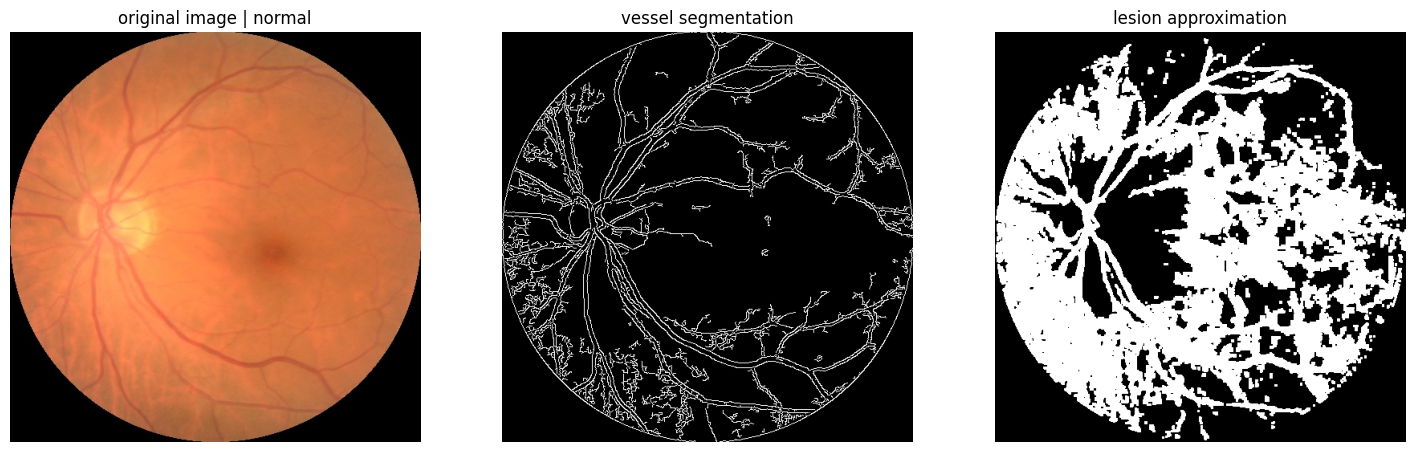

mean rgb: [171.28316879  95.34960938  55.40127945]
std rgb: [91.76792677 51.71154252 30.31295991]
brightness: 109.33915710449219
feature vector: [20.00650405883789, 115.22489547729492, 171.2831687927246, 95.349609375, 55.40127944946289, 91.76792676628543, 51.711542518166624, 30.31295991282416, 109.33915710449219]


In [27]:
import cv2 
import numpy as np 
import os 
from matplotlib import pyplot as plt 

#loading img

dataset_path= "/kaggle/input/eye-diseases-classification/dataset/normal"
images= os.listdir(dataset_path)

img_example= cv2.imread(os.path.join(dataset_path, images[0]))
img_example = cv2.cvtColor(img_example, cv2.COLOR_BGR2RGB)

# vessel segmentation

def vessel_segmentation(img):
    gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe= cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    edges = cv2.Canny(gray, 30,100)
    return edges

vessels = vessel_segmentation(img_example)

# lesion approximation 

def lesion_segmentation(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_red1= np.array([0,50,50])
    upper_red1= np.array([10,255,255])
    lower_red2=np.array([160,50,50])
    upper_red2=np.array([180,255,255])

    
    mask1= cv2.inRange(hsv, lower_red1, upper_red1)
    mask2= cv2.inRange(hsv, lower_red2, upper_red2)

    mask=cv2.bitwise_or(mask1, mask2)
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask 
lesions = lesion_segmentation(img_example)


# plotting 

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(img_example)
plt.axis('off')
plt.title("original image | normal")

plt.subplot(1,3,2)
plt.imshow(vessels, cmap='gray')
plt.axis('off')
plt.title("vessel segmentation")

plt.subplot(1,3,3)
plt.imshow(lesions, cmap='gray')
plt.axis('off')
plt.title("lesion approximation")
plt.show()

def color_feature(img):
    mean_rgb= np.mean(img, axis=(0,1))
    std_rgb= np.std(img, axis=(0,1))
    brightness = np.mean(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
    return mean_rgb, std_rgb, brightness    

mean_rgb, std_rgb, brightness = color_feature(img_example)
print('mean rgb:', mean_rgb)
print('std rgb:', std_rgb)
print('brightness:', brightness)

vessel_density = vessels.sum() / vessels.size
lesion_area = lesions.sum() / lesions.size
feature_vector= [vessel_density, lesion_area, *mean_rgb, *std_rgb, brightness]
print("feature vector:", feature_vector)




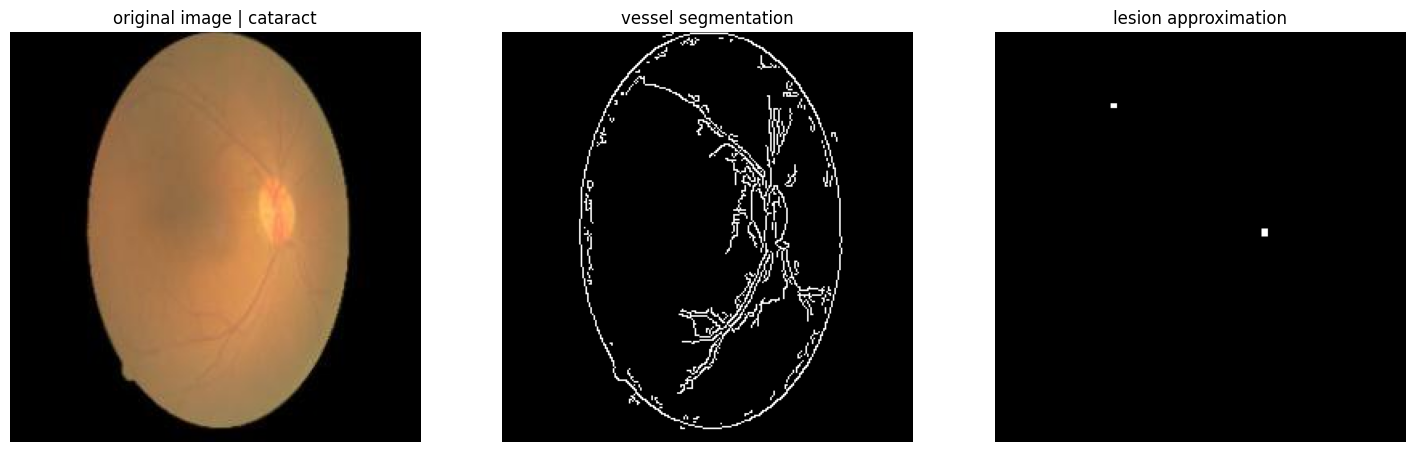

mean rgb: [83.60249329 60.25895691 37.77996826]
std rgb: [87.18355634 62.3840837  38.86406456]
brightness: 61.58564249674479
feature vector: [10.918121337890625, 0.12451171875, 83.60249328613281, 60.25895690917969, 37.77996826171875, 87.18355634433956, 62.38408369898751, 38.864064561680365, 61.58564249674479]


In [28]:
import cv2 
import numpy as np 
import os 
from matplotlib import pyplot as plt 

#loading img

dataset_path= "/kaggle/input/eye-diseases-classification/dataset/cataract"
images= os.listdir(dataset_path)

img_example= cv2.imread(os.path.join(dataset_path, images[0]))
img_example = cv2.cvtColor(img_example, cv2.COLOR_BGR2RGB)

# vessel segmentation

def vessel_segmentation(img):
    gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe= cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    edges = cv2.Canny(gray, 30,100)
    return edges

vessels = vessel_segmentation(img_example)

# lesion approximation 

def lesion_segmentation(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_red1= np.array([0,50,50])
    upper_red1= np.array([10,255,255])
    lower_red2=np.array([160,50,50])
    upper_red2=np.array([180,255,255])

    
    mask1= cv2.inRange(hsv, lower_red1, upper_red1)
    mask2= cv2.inRange(hsv, lower_red2, upper_red2)

    mask=cv2.bitwise_or(mask1, mask2)
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask 
lesions = lesion_segmentation(img_example)


# plotting 

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(img_example)
plt.axis('off')
plt.title("original image | cataract")

plt.subplot(1,3,2)
plt.imshow(vessels, cmap='gray')
plt.axis('off')
plt.title("vessel segmentation")

plt.subplot(1,3,3)
plt.imshow(lesions, cmap='gray')
plt.axis('off')
plt.title("lesion approximation")
plt.show()

def color_feature(img):
    mean_rgb= np.mean(img, axis=(0,1))
    std_rgb= np.std(img, axis=(0,1))
    brightness = np.mean(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
    return mean_rgb, std_rgb, brightness    

mean_rgb, std_rgb, brightness = color_feature(img_example)
print('mean rgb:', mean_rgb)
print('std rgb:', std_rgb)
print('brightness:', brightness)

vessel_density = vessels.sum() / vessels.size
lesion_area = lesions.sum() / lesions.size
feature_vector= [vessel_density, lesion_area, *mean_rgb, *std_rgb, brightness]
print("feature vector:", feature_vector)


